# Homework 11

## ASTR 5900, Fall 2017, University of Oklahoma

### More Regression

# Problem 1

Polymer dielectrics have many applications such as in organic photovoltaics and wearable electronics.  One property that a polymer should have as a dielectric is a high bandgap energy.  There are two compounding difficulties in searching for polymer candidates for these technologies: the volume of chemical space is vast and the evaluation of material properties via *ab initio* methods are computationally expensive.  However it is possible to build a model to  predict the properties of polymers using regression, a supervised learning method.

In this problem we will perform regression on the bandgap energy of certain polymers.  The data is located in `polymers.csv`.  Featured are 284 unique 4-block materials composed of 7 different molecular building blocks: $CH_2$, $NH$, $CO$, $C_6 H_4$, $C_4 H_2 S$, $CS$, and $O$.  The polymers are understood to repeat indefinitely.

### Part A

The choice of how data is represented is an important part of machine learning.  One such representation of our molecule data is the $M_{II}$ fingerprint, which is a normalized count of the number of different types of pairs of building blocks in a polyer.  The representation is therefore a $7 \times 7$ matrix with these specifications:

1. The sum of all elements in the matrix should be equal to 4 (since we are dealing with 4-block materials) $$ \sum^7_{i,j} M_{ij} = 4$$
2. The sum of elements in any row or column of $M$ should be equal to the total number of blocks of that kind in the polymer.
3. The period symmetry in the polymer dictates that $M$ is a symmetric matrix.  In other words, polymers have the same bandgap energy if they are mirrored.
4. The diagonal elements of $M$ are integers.
#### \# number 4 might be misc sentence


Transform the data from `polymers.csv` so that each molecule is represented in the $M_{II}$ fingerprint.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from colours import colours
import pickle
import scipy
import sklearn
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
import random
import matplotlib.colors as colors
import os
import scipy.stats as st
from sklearn.gaussian_process.kernels import RBF

In [2]:
hwdatafile = 'hw11-1a.dat'
molecules=['CH2','NH','CO','C6H4','C4H2S','CS','O']
with open(hwdatafile,'r') as f:
    dictraw = pickle.load(f)
allchains = [x for x in dictraw]

In [3]:
print(len(dictraw))

284


In [4]:
finaldict = dictraw.copy()
for x in allchains:
    blocks = x.split('-')
    temp   = np.zeros((7,7))
    
    indexinglist = [molecules.index(i) for i in blocks]
    tindexinglist = indexinglist[::-1]
    indexinglist.append(indexinglist[0])
    tindexinglist.append(tindexinglist[0])
    #print x,indexinglist
    
    for i,p in enumerate(indexinglist):
        if i < (len(indexinglist) -1):
            temp[int(p),indexinglist[i+1]] += 0.5
    for i,p in enumerate(tindexinglist):
        if i < (len(tindexinglist) -1):
            temp[int(p),tindexinglist[i+1]] += 0.5
    # save the matrix
    finaldict[x] = [finaldict[x],temp]

In [5]:
print(len(finaldict))

284


### Part B

Perform Kernel Ridge Regression on the data using `sklearn.kernel_ridge.KernelRidge`.  Use a Gaussian kernel with a width ($\sigma$) of 25.  Use an alpha parameter of $10^{-5}$.

You must define your own Gaussian kernel that goes like $$ k(\vec{x}, \vec{v}) = \exp\left( -\frac{1}{2\sigma^2} || \vec{x} - \vec{v}||^2\right)$$
Read this link on `KernelRidge` objects to understand how to implement it: http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge

Use the first 200 data points to train your model, then the remaining 84 to test it.  Calculate the standard error of the test set.  Plot the model values of the data points against their target values, and color each point according to its membership in the test or training set.  Use appropriate labels.


In [6]:
mxtrain = []
bgtrain = []
mxtest = []
bgtest = []
for i,x in enumerate(finaldict):
    if i < 200:
        mxtrain.append(finaldict[x][1].flatten())
        bgtrain.append(finaldict[x][0][3])
    else:
        mxtest.append(finaldict[x][1].flatten())
        bgtest.append(finaldict[x][0][3])
mxtrain=np.array(mxtrain)
bgtrain=np.array(bgtrain)
mxtest=np.array(mxtest)
bgtest=np.array(bgtest)
print(mxtrain.shape,bgtrain.shape)
print(mxtest.shape,bgtest.shape)
print(mxtrain[0])
print(bgtrain[0])

((200, 49), (200,))
((84, 49), (84,))
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.5  0.   0.5  0.   0.
  0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.5  0.5  0.   0. ]
2.516


In [7]:
'''
class gauss_kernel(object):
    def __init__(self,kernlen=10,sig=25):
        self.sig = sig
        self.kernlen = kernlen
        
    def get_params(self):
        return self.kernlen,self.sig
    
    def set_params(self,paramname,paramval):
        self.paramname = paramval
        
    def is_stationary(self):
        return True
    
    def __cal__(self):
        """Returns a 1D Gaussian kernel array."""
        interval = (2*self.sig+1.)/(self.kernlen)
        x = np.linspace(-self.sig-interval/2., self.sig+interval/2., self.kernlen+1)
        kern1d = np.diff(st.norm.cdf(x))
        kernel_raw = np.sqrt(kern1d, kern1d)
        kernel = kernel1d/kernel_raw
        return kernel
'''
def gauss_kernel(X,V,sig=25):
    return np.exp(-0.5*(np.inner((X-V),(X-V))/sig)**2)

In [8]:
kr = KernelRidge(alpha=10e-5,kernel=gauss_kernel)
kr.fit(mxtrain,bgtrain)

KernelRidge(alpha=0.0001, coef0=1, degree=3, gamma=None,
      kernel=<function gauss_kernel at 0x7fe4bfe97320>, kernel_params=None)

In [9]:
x_kr = kr.predict(mxtrain)
print(x_kr.shape)
y_kr = kr.predict(mxtest)
print(y_kr.shape)

(200,)
(84,)


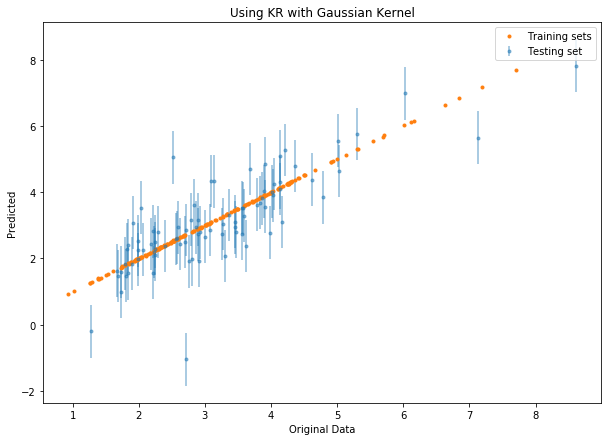

Std: 0.794166803504


In [10]:
plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel("Original Data")
plt.ylabel("Predicted")
plt.title("Using KR with Gaussian Kernel")
y_kr_std = np.std(y_kr-bgtest)
plt.errorbar(bgtest,y_kr,yerr=y_kr_std,fmt='.',label='Testing set',alpha=0.5)
plt.plot(bgtrain,x_kr,'.',label="Training sets")
plt.legend()
plt.show()
print("Std: {}".format(y_kr_std))

# Problem 2

Now we will be performing Gaussian Process Regression on the same polymer data from Problem 1.

Use an `sklearn.model_selection.GridSearchCV` object to optimize the hyperparameters of an `sklearn.gaussian_process.GaussianProcessRegressor` object applied to the polymer data.  Use the same split as before to train, then test the model.  Plot the model and true results as in Problem 1, and determine the error.  Comment on your results and compare to Problem 1.

There are examples on the sci-kit learn website on how to use `GridSearchCV`, however they are applied to other models such as `KernelRidge`.  The concept is the same, so you should be able to figure out how to use them for our GP objects.  One such example is here: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py

In [11]:
param_grid = {"alpha": np.linspace(10e-7,0.0001,5),\
              "kernel": [RBF(l)
                         for l in np.logspace(10e-5, 100, 5)]}
gpr = GridSearchCV(GaussianProcessRegressor(), cv=5, param_grid=param_grid)
gpr.fit(mxtrain,bgtrain)
print(gpr.get_params)

<bound method GridSearchCV.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-06,   2.57500e-05,   5.05000e-05,   7.52500e-05,
         1.00000e-04]), 'kernel': [RBF(length_scale=1), RBF(length_scale=1e+25), RBF(length_scale=1e+50), RBF(length_scale=1e+75), RBF(length_scale=1e+100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)>


In [12]:
x_gpr = gpr.predict(mxtrain)
print(x_gpr.shape)
y_gpr = gpr.predict(mxtest)
print(y_gpr.shape)

(200,)
(84,)


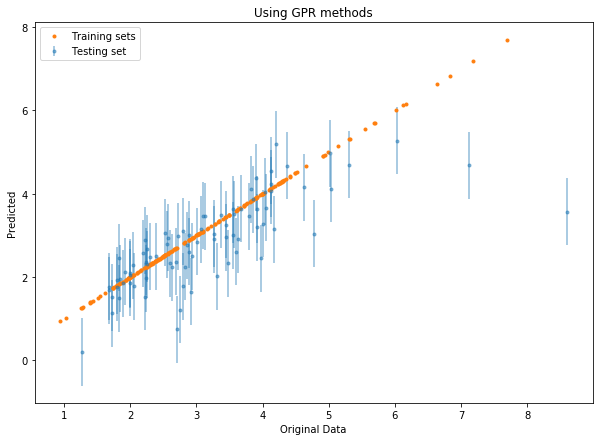

Std: 0.80407867036


In [13]:
plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel("Original Data")
plt.ylabel("Predicted")
plt.title("Using GPR methods")
y_gpr_std = np.std(y_gpr-bgtest)
plt.errorbar(bgtest,y_gpr,yerr=y_gpr_std,fmt='.',label='Testing set',alpha=0.5)
plt.plot(bgtrain,x_gpr,'.',label="Training sets")
plt.legend()
plt.show()
print("Std: {}".format(y_gpr_std))

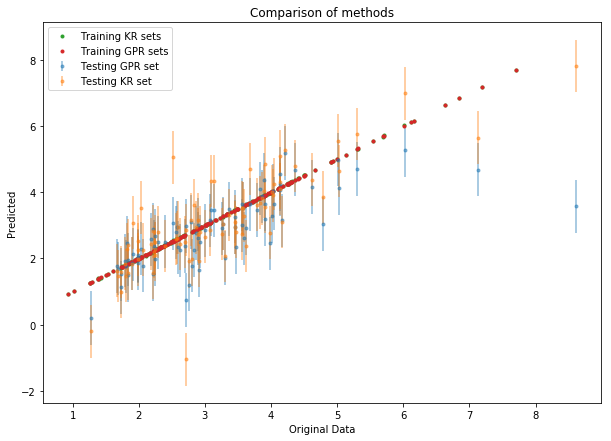

Std: KR 0.794166803504 vs GPR 0.80407867036


In [14]:
plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel("Original Data")
plt.ylabel("Predicted")
plt.title("Comparison of methods")
plt.errorbar(bgtest,y_gpr,yerr=y_gpr_std,fmt='.',label='Testing GPR set',alpha=0.5)
plt.errorbar(bgtest,y_kr,yerr=y_kr_std,fmt='.',label='Testing KR set',alpha=0.5)
plt.plot(bgtrain,x_kr,'.',label="Training KR sets")
plt.plot(bgtrain,x_gpr,'.',label="Training GPR sets")
plt.legend()
plt.show()
print("Std: KR {} vs GPR {}".format(y_kr_std,y_gpr_std))

### Just by eye it seems the GPR does a better job than the KR during regions of high density but fails during periods of low density similar to the outer regions of the data. They both are fairly close though for the high density regions though. I bet *not going to* if I sliced the data to the inner regions the STD would be much closer to eachother albeit the standard deviations are close.

# Problem Z

Comment on the amount of time this assignment required.

### I am retarded and it took me awhile to implement the gaussian kernel because I was inadvertantly taking the outer product of the vectors
### THe actual time I record here doesn't matter so I wont
### This is like having a safe word with your SO but your SO ignores it.
